In [380]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [381]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import re
import statsmodels.api as sm
import statsmodels.formula.api as smf
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot
from fbprophet.diagnostics import cross_validation, performance_metrics
from datetime import datetime
import geopandas as gpd
import sys
sys.path.append('energy/')
import utils
from hts import hts, orderHier
%matplotlib inline

In [382]:
import warnings
warnings.simplefilter("ignore", DeprecationWarning)
warnings.simplefilter("ignore", FutureWarning)

In [383]:
pd.options.mode.chained_assignment = None  # default='warn'

In [445]:
#viz setup
# sns.set(style='whitegrid',font_scale=1.75,rc={"axes.spines.top":False,"axes.spines.right":False, "lines.linewidth": 2.5,'lines.markersize': 10},color_codes=False,palette=sns.color_palette(['#27a3aa','#f76d23','#70d6e3','#ffbb31','#b1c96d','#cce18a','#1c4c5d','#787642']))
sns.set(style='whitegrid',font_scale=1.25,rc={"axes.spines.top":False,"axes.spines.right":False, "lines.linewidth": 2.5,'lines.markersize': 10},color_codes=False,palette=sns.color_palette(['#27a3aa','#f76d23','#70d6e3','#ffbb31','#b1c96d','#cce18a','#1c4c5d','#787642']))

In [385]:
energy_data = pd.read_csv('energy/energy_data.csv')

In [386]:
energy_data.date = pd.to_datetime(energy_data.date)

In [387]:
energy_data = energy_data.dropna()
energy_data = energy_data[energy_data.consumers > 0]

In [388]:
energy_data.head()

,month,sales_mkwh,state,sector,consumers,price,revenue,use_per_capita,region,cooling_days,...,RES,time,year,mon,season,date,num_days,num_hols,pct_weekdays,y
0,202010,2137.29371,AL,RES,2286425.0,13.07,27934.428790,934.775341,ESC,66.799124,...,1,154,2020,10,fall,2020-10-01,31,10,0.677419,30.154043
1,202009,2875.42861,AL,RES,2325509.0,13.18,37898.149080,1236.472794,ESC,211.894717,...,1,153,2020,9,fall,2020-09-01,30,9,0.700000,41.215760
2,202008,3569.57496,AL,RES,2322835.0,12.76,45547.776490,1536.732036,ESC,388.011338,...,1,152,2020,8,summer,2020-08-01,31,10,0.677419,49.572001
3,202007,3587.72858,AL,RES,2319406.0,12.69,45528.275680,1546.830775,ESC,462.496476,...,1,151,2020,7,summer,2020-07-01,31,9,0.709677,49.897767
4,202006,2912.11315,AL,RES,2314926.0,12.93,37653.623029,1257.972458,ESC,297.090326,...,1,150,2020,6,summer,2020-06-01,30,8,0.733333,41.932415


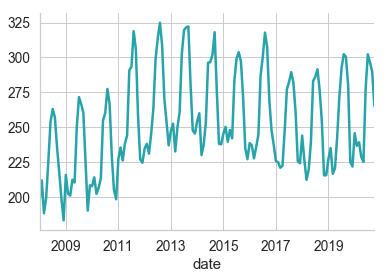

In [389]:
energy_data[(energy_data.state == 'TX')&(energy_data.sector=='COM')].set_index('date').sort_index().y.plot()

#### Removing outliers

In [390]:
energy_data = energy_data.set_index('date')

In [391]:
filtered_data = energy_data.groupby(['state','sector']).apply(utils.median_filter).reset_index()

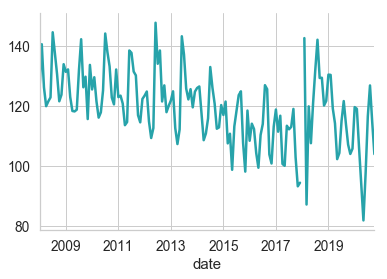

In [392]:
filtered_data[(filtered_data.state=='ME')&(filtered_data.sector=='COM')].set_index('date').y.plot()

In [393]:
energy_data = energy_data.reset_index().drop(columns='y').merge(filtered_data,how='left',on=['date','state','sector'])

## Heirarchical prophet

In [ ]:
heir_energy_data = energy_data.copy()
heir_energy_data.y = heir_energy_data.y/heir_energy_data.pct_weekdays
heir_energy_data, nodes = orderHier(heir_energy_data[(heir_energy_data.year<2019)&(heir_energy_data.region=='ESC')&(heir_energy_data.sector=='RES')][['date','state','y']],1)

In [ ]:
heir_energy_data.head()

In [ ]:
myDict = hts(heir_energy_data, 21, nodes, freq='MS', method = "OLS",yearly_seasonality=5,weekly_seasonality=False, daily_seasonality=False,mcmc_samples=300, changepoint_prior_scale=0.01,include_history =True)

In [ ]:
tmp = energy_data[(energy_data.state=='AL')&(energy_data.sector=='RES')]
tmp = tmp[['date','y','pct_weekdays']].merge(myDict['AL'][['ds','yhat']],how='left',left_on=['date'],right_on='ds').set_index('date')
tmp.yhat = tmp.yhat*tmp.pct_weekdays
tmp[['y','yhat']].plot()

In [ ]:
tmp.loc[:,['y','yhat']].corr()

## FB Prophet analysis

Prediction Correlation: 0.9713813989009894


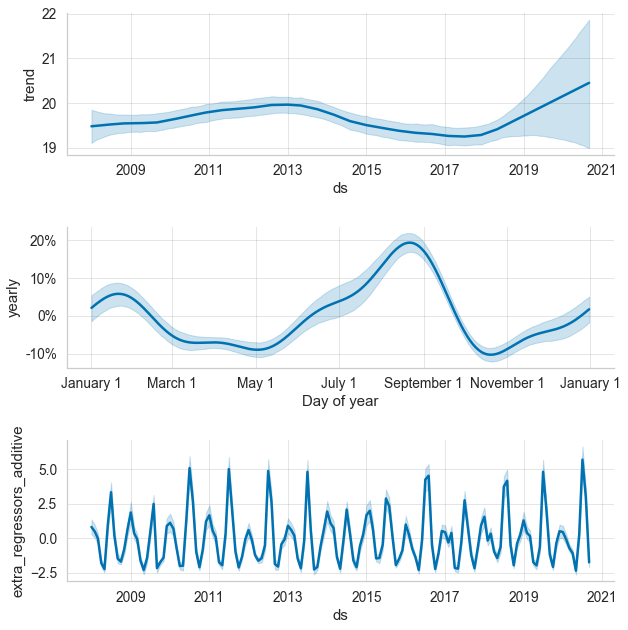

In [394]:
utils.get_model_for_state_sector(energy_data,'NY','RES',changepoint_prior_scale=0.1)

Prediction Correlation: 0.9922950883008694


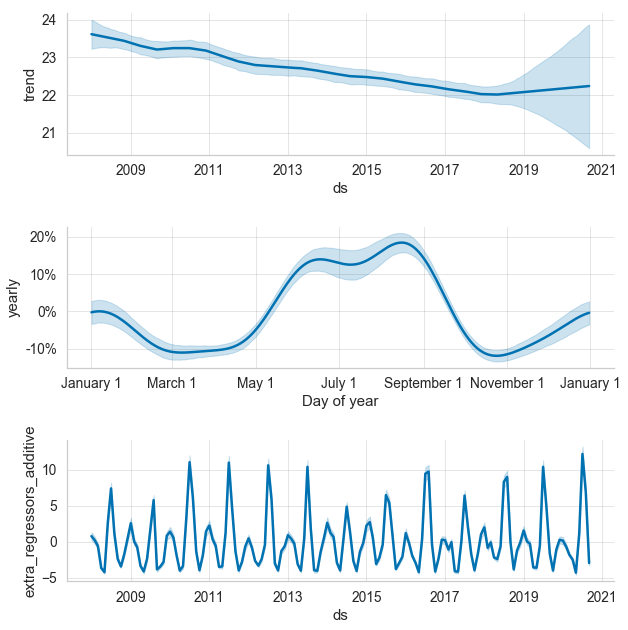

In [395]:
utils.get_model_for_state_sector(energy_data,'NJ','RES',changepoint_prior_scale=0.1)

Prediction Correlation: 0.9729081018038215


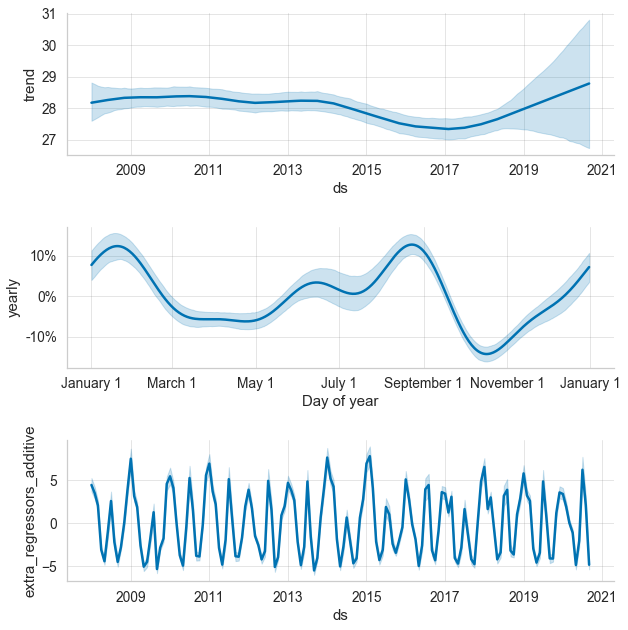

In [396]:
utils.get_model_for_state_sector(energy_data,'PA','RES',changepoint_prior_scale=0.1)

### Running for each State and Sector

In [399]:
df_train.tail()

,ds,y,heating_days,cooling_days,pct_weekdays
127,2018-08-01,52.674071,24.703463,343.648497,0.741935
128,2018-09-01,45.544775,89.151316,238.030680,0.633333
129,2018-10-01,25.641784,383.810045,45.052947,0.709677
130,2018-11-01,22.226264,678.400203,4.881446,0.666667
131,2018-12-01,26.854866,897.261451,0.000000,0.645161


In [397]:
# %%timeit
states = list(energy_data.state.unique())
sectors = list(energy_data.sector.unique())
idx = 0
for state in states:
    for sector in sectors:
        
        state_sector = "{}-{}".format(state, sector)
        print(state_sector)
        ## Defining Training Data 
        df_model = energy_data[(energy_data.state == state)&(energy_data.sector == sector)].copy().set_index('date').sort_index()
        df_train, df_test = utils.prepare_data(df_model[['y','heating_days','cooling_days','pct_weekdays']], 2019)
        regressors_df = df_model[['heating_days','cooling_days','pct_weekdays']].copy()
        
        ## Fitting model
        m = Prophet(seasonality_mode='multiplicative',
                yearly_seasonality=5,daily_seasonality=False,weekly_seasonality=False,mcmc_samples=300,
                changepoint_prior_scale=0.5, changepoint_range=0.95)
        m.add_regressor('heating_days', mode='additive')
        m.add_regressor('cooling_days', mode='additive')
        m.add_regressor('pct_weekdays', mode='additive')
        m_fit = m.fit(df_train,control={'max_treedepth': 12})
        
        ## Getting forecasts
        future = m_fit.make_future_dataframe(periods = 21, freq = 'MS')
        future = utils.add_regressor_to_future(future, regressors_df)
        forecast = m_fit.predict(future)
        # fig = m_fit.plot(forecast)
        forecast['state'] = state
        forecast['sector'] = sector
               
        if idx == 0:
            predictions = forecast[['ds','yhat','state','sector']].copy()    
        else:
            predictions = predictions.append(forecast[['ds','yhat','state','sector']])
            
        idx = idx +1


AL-RES
AL-COM
AZ-RES


Process ForkPoolWorker-5307:
Process ForkPoolWorker-5306:
Process ForkPoolWorker-5308:
Process ForkPoolWorker-5305:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/conda/envs/py3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/opt/conda/envs/py3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/opt/conda/envs/py3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/envs/py3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/opt/conda/envs/py3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/opt/conda/envs/py3/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/opt/conda/envs/py3/lib/python3.6/m

KeyboardInterrupt: 

In [ ]:
predictions = predictions.rename(columns={'ds':'date'})

In [ ]:
predictions.head()

In [ ]:
energy_data = energy_data.merge(predictions,how='left',on=['date','state','sector'])

In [ ]:
correlations = energy_data[energy_data.year==2019].groupby(['state','sector']).apply(lambda x: np.corrcoef(x.y, x.yhat)[0, 1]).reset_index().rename(columns={0:'correl'})

In [ ]:
energy_data['pct_error'] = (energy_data['y'] - energy_data['yhat'])*100/energy_data['y']

In [ ]:
sns.boxplot(y='pct_error',x='sector',data=energy_data[energy_data.year<2020])

In [ ]:
fig,ax = plt.subplots(figsize=(10,6))
sns.boxplot(y='pct_error',x='mon',hue='sector',data=energy_data[(energy_data.year<2020)])

In [ ]:
fig,ax = plt.subplots(figsize=(10,6))
sns.boxplot(y='pct_error',x='year',hue='sector',data=energy_data[(energy_data.year<2020)])

In [ ]:
fig,ax = plt.subplots(figsize=(20,6))
sns.boxplot(y='pct_error',x='state',hue='sector',data=energy_data[(energy_data.year<2020)])

In [ ]:
fig,ax = plt.subplots(figsize=(20,6))
sns.scatterplot(x='state',y='correl',hue='sector',data=correlations)

In [ ]:
utils.get_model_for_state_sector(energy_data,'FL','RES',plot_forecast=True, changepoint_prior_scale=0.5,split_year=2020)

In [ ]:
# fig,ax = plt.subplots(3 ,2,figsize=(10,6))
state_plot(energy_data,'FL','RES',year_lim=2019)
state_plot(energy_data,'FL','COM',year_lim=2019)
state_plot(energy_data,'NY','RES',year_lim=2019)
state_plot(energy_data,'NY','COM',year_lim=2019)
state_plot(energy_data,'AL','RES',year_lim=2019)
state_plot(energy_data,'AL','COM',year_lim=2019)
state_plot(energy_data,'TX','RES',year_lim=2019)
state_plot(energy_data,'TX','COM',year_lim=2019)
state_plot(energy_data,'CA','RES',year_lim=2019)
state_plot(energy_data,'CA','COM',year_lim=2019)
state_plot(energy_data,'USA','RES',year_lim=2019)
state_plot(energy_data,'USA','COM',year_lim=2019)


### Training with 2019 data

In [400]:
# %%timeit
states = list(energy_data.state.unique())
sectors = list(energy_data.sector.unique())
years = [2015,2016,2017,2018,2019,2020]
idx = 0

for year in years:
    for state in states:
        for sector in sectors:
        
            state_sector = "{}-{}".format(state, sector)
#             print(state_sector)
            ## Defining Training Data 
            df_model = energy_data[(energy_data.state == state)&(energy_data.sector == sector)].copy().set_index('date').sort_index()
            df_train, df_test = utils.prepare_data(df_model[['y','heating_days','cooling_days','pct_weekdays']], year)
            regressors_df = df_model[['heating_days','cooling_days','pct_weekdays']].copy()

            ## Fitting model
            m = Prophet(seasonality_mode='multiplicative',yearly_seasonality=5,
                        daily_seasonality=False,weekly_seasonality=False,mcmc_samples=300,
                        changepoint_prior_scale=0.25, changepoint_range=0.95)
            m.add_regressor('heating_days', mode='additive')
            m.add_regressor('cooling_days', mode='additive')
            m.add_regressor('pct_weekdays', mode='additive')
            m_fit = m.fit(df_train,control={'max_treedepth': 15})

            ## Getting forecasts
            future = m_fit.make_future_dataframe(periods = 12, freq = 'MS')
            future = utils.add_regressor_to_future(future, regressors_df)
            forecast = m_fit.predict(future)
            # fig = m_fit.plot(forecast)
            forecast['state'] = state
            forecast['sector'] = sector
            forecast['pred_year'] = year

            if idx == 0:
                predictions = forecast[['ds','yhat','state','sector','pred_year']].copy()    
            else:
                predictions = predictions.append(forecast[['ds','yhat','state','sector','pred_year']])

            idx = idx +1


In [401]:
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,cooling_days,...,pct_weekdays,pct_weekdays_lower,pct_weekdays_upper,yearly,yearly_lower,yearly_upper,yhat,state,sector,pred_year
149,2020-06-01,195.829297,206.159322,214.318060,192.910377,198.863297,5.915170,3.882356,8.122597,14.659027,...,1.911184,1.547428,2.310521,0.042485,0.031262,0.053355,210.064369,USA,COM,2020
150,2020-07-01,195.562983,221.721016,230.680052,192.291639,199.011132,21.485382,17.684873,25.333957,31.877163,...,0.941391,0.762216,1.138092,0.046845,0.030301,0.062876,226.209453,USA,COM,2020
151,2020-08-01,195.287792,217.627422,226.984683,191.623086,199.084922,15.572945,12.356126,18.916773,27.200686,...,-0.381054,-0.460675,-0.308528,0.058411,0.043940,0.072094,222.267778,USA,COM,2020
152,2020-09-01,195.012600,205.925675,216.541748,190.937359,199.209620,-1.743401,-3.229764,-0.227257,7.308201,...,0.544657,0.440993,0.658462,0.091986,0.083309,0.100226,211.207646,USA,COM,2020
153,2020-10-01,194.746286,185.305201,196.031877,190.263986,199.454965,-7.798248,-8.577734,-7.044079,-3.893241,...,-0.381054,-0.460675,-0.308528,0.018885,0.013139,0.024682,190.625849,USA,COM,2020


In [402]:
predictions.state.value_counts()

IA     1508
IN     1508
GA     1508
MT     1508
PA     1508
WI     1508
NH     1508
NJ     1508
OK     1508
KY     1508
RI     1508
NY     1508
CO     1508
CA     1508
ID     1508
MA     1508
TN     1508
WA     1508
WV     1508
FL     1508
ND     1508
MI     1508
AZ     1508
AR     1508
KS     1508
IL     1508
LA     1508
OH     1508
SD     1508
NC     1508
ME     1508
MD     1508
VA     1508
UT     1508
NV     1508
MO     1508
CT     1508
DC     1508
NE     1508
MN     1508
VT     1508
AL     1508
NM     1508
WY     1508
MS     1508
DE     1508
USA    1508
SC     1508
OR     1508
TX     1508
Name: state, dtype: int64

In [403]:
pred_over_time = predictions[predictions.ds.dt.year==predictions.pred_year].merge(energy_data[['y','date','state','sector']],how='left',left_on=['ds','state','sector'],right_on=['date','state','sector'])

In [404]:
pred_over_time['pct_error'] = (pred_over_time['y'] - pred_over_time['yhat'])*100/pred_over_time['y']

In [405]:
pred_over_time[(pred_over_time.sector=='RES')&(pred_over_time.ds >= '2020-03-01')].sort_values('pct_error')

,ds,yhat,state,sector,pred_year,y,date,pct_error
6889,2020-10-01,27.046669,VA,RES,2020,22.250263,2020-10-01,-21.556624
6122,2020-03-01,21.219765,DC,RES,2020,18.712318,2020-03-01,-13.399982
6722,2020-03-01,26.659587,PA,RES,2020,23.676767,2020-03-01,-12.598087
6582,2020-03-01,18.405819,NM,RES,2020,16.615543,2020-03-01,-10.774708
6049,2020-10-01,31.153475,AR,RES,2020,28.361468,2020-10-01,-9.844365
...,...,...,...,...,...,...,...,...
6924,2020-05-01,24.950282,WV,RES,2020,29.786767,2020-05-01,16.237024
6144,2020-05-01,20.223239,DE,RES,2020,24.592314,2020-05-01,17.766018
6404,2020-05-01,15.302307,MI,RES,2020,18.724421,2020-05-01,18.276208
6748,2020-09-01,17.060822,RI,RES,2020,21.102041,2020-09-01,19.150842


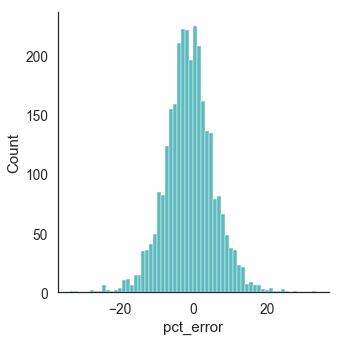

In [422]:
# fig,ax = plt.subplots(figsize=(10,8))
sns.displot(pred_over_time[(pred_over_time.ds.dt.year<2020)&(pred_over_time.sector=='RES')].pct_error)

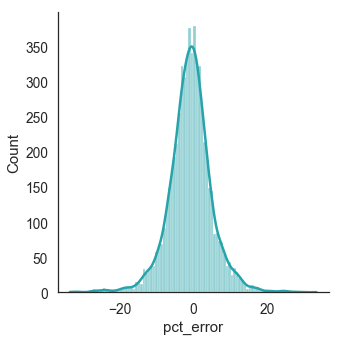

In [433]:
# fig,ax = plt.subplots(figsize=(10,8))
sns.displot(pred_over_time[(pred_over_time.ds.dt.year<2020)].pct_error, kde=True)


In [440]:
pred_over_time[(pred_over_time.ds.dt.year<2020)].pct_error.quantile([0.05,0.1,0.9,0.95])

0.05   -9.970950
0.10   -7.387580
0.90    5.775134
0.95    8.518211
Name: pct_error, dtype: float64

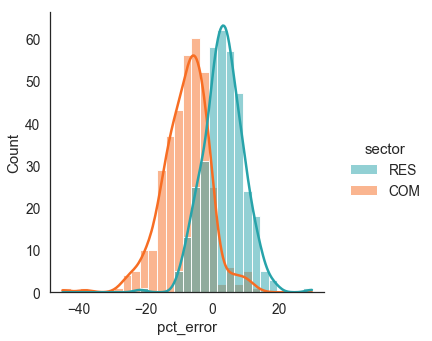

In [435]:
# fig,ax = plt.subplots(figsize=(10,8))
sns.displot(data=pred_over_time[(pred_over_time.ds > '2020-03-01')], x='pct_error', kde=True, hue='sector')

In [442]:
pred_over_time[(pred_over_time.ds >= '2020-03-01')&(pred_over_time.sector=='COM')].pct_error.median()

-6.445302635116522

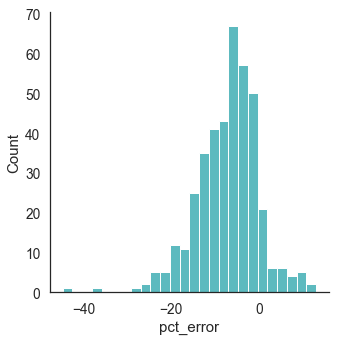

In [425]:
# fig,ax = plt.subplots(figsize=(10,8))
sns.displot(pred_over_time[(pred_over_time.ds >= '2020-03-01')&(pred_over_time.sector=='COM')].pct_error)

In [409]:
predictions_2020 = predictions[predictions.pred_year==2020].rename(columns={'ds':'date','yhat':'yhat_20'})
energy_data = energy_data.merge(predictions_2020,how='left',on=['date','state','sector'])

In [410]:
energy_data['pct_error_20'] = (energy_data['y'] - energy_data['yhat_20'])*100/energy_data['y']

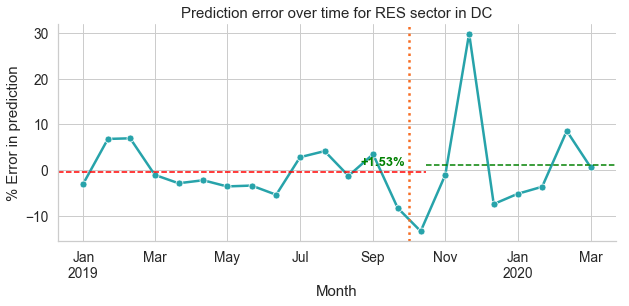

In [411]:
utils.state_plot(energy_data,'DC','RES',year_lim=2019,col='pct_error_20')

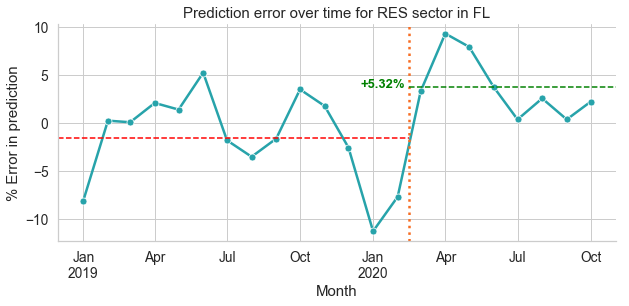

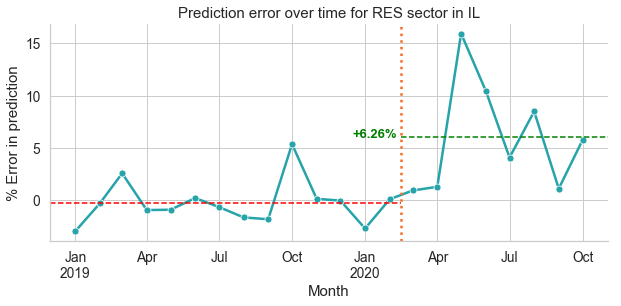

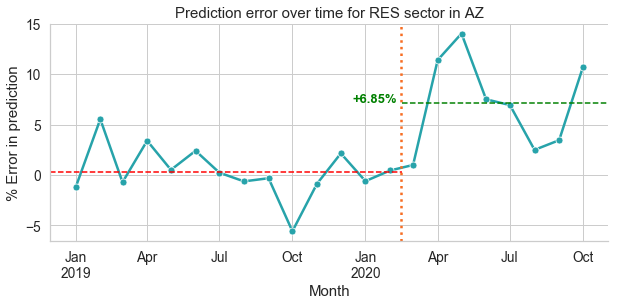

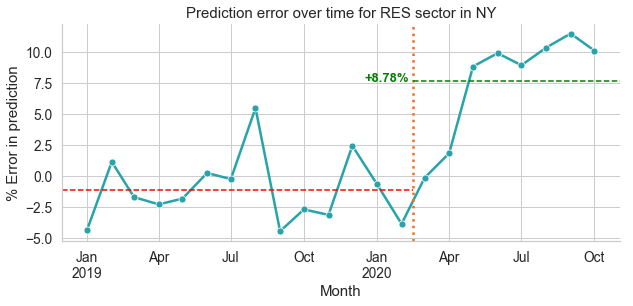

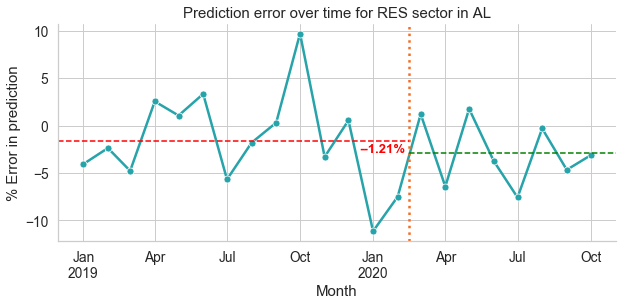

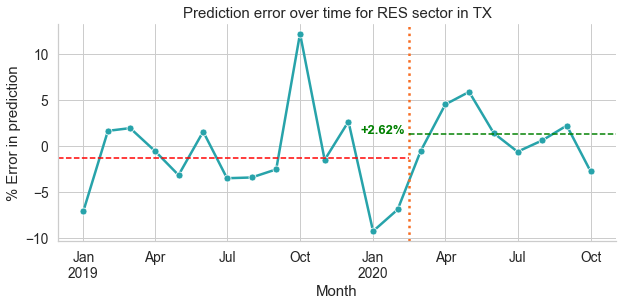

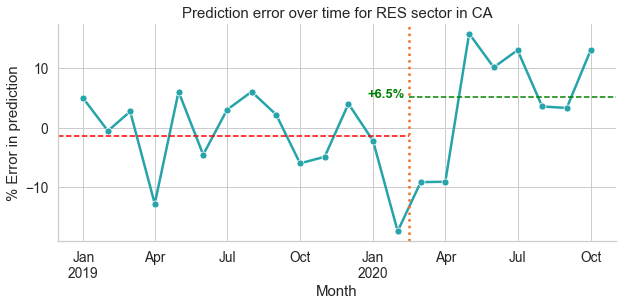

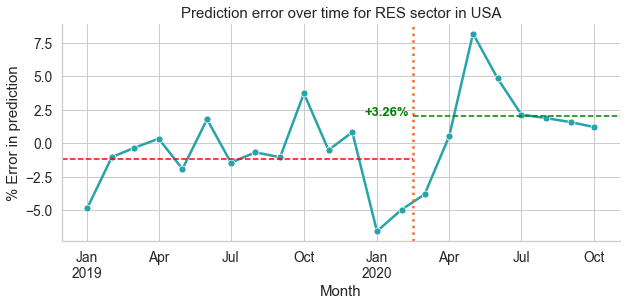

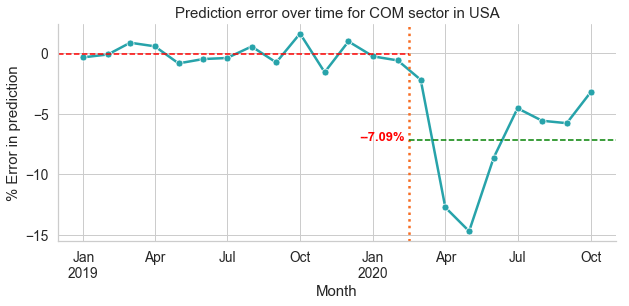

In [446]:
# fig,ax = plt.subplots(3 ,2,figsize=(10,6))
utils.state_plot(energy_data,'FL','RES',year_lim=2019,col='pct_error_20')
utils.state_plot(energy_data,'IL','RES',year_lim=2019,col='pct_error_20')
utils.state_plot(energy_data,'AZ','RES',year_lim=2019,col='pct_error_20')
# utils.state_plot(energy_data,'FL','COM',year_lim=2019,col='pct_error_20')
utils.state_plot(energy_data,'NY','RES',year_lim=2019,col='pct_error_20')
# utils.state_plot(energy_data,'NY','COM',year_lim=2019,col='pct_error_20')
utils.state_plot(energy_data,'AL','RES',year_lim=2019,col='pct_error_20')
# utils.state_plot(energy_data,'AL','COM',year_lim=2019,col='pct_error_20')
utils.state_plot(energy_data,'TX','RES',year_lim=2019,col='pct_error_20')
# utils.state_plot(energy_data,'TX','COM',year_lim=2019,col='pct_error_20')
utils.state_plot(energy_data,'CA','RES',year_lim=2019,col='pct_error_20')
# utils.state_plot(energy_data,'CA','COM',year_lim=2019,col='pct_error_20')
utils.state_plot(energy_data,'USA','RES',year_lim=2019,col='pct_error_20')
utils.state_plot(energy_data,'USA','COM',year_lim=2019,col='pct_error_20')


In [413]:
def mean_errors(df, col='pct_error_20'):
    pre_covid = df[(df.date<'2020-03-01')&(df.date >= '2019-01-01')][col].mean()
    post_covid = df[df.date>='2020-03-01'][col].mean()
    diff = post_covid - pre_covid
    return diff
#     return {'pre_covid':pre_covid, 'post_covid':post_covid}

In [414]:
mean_change = pd.DataFrame(energy_data.groupby(['state','sector']).apply(mean_errors).reset_index().rename(columns={0:'change'}))

In [415]:
mean_res_change = mean_change[mean_change.sector=="RES"]

In [416]:
mean_res_change

,state,sector,change
1,AL,RES,-1.209087
3,AR,RES,-3.622929
5,AZ,RES,6.852560
7,CA,RES,6.501631
9,CO,RES,5.653217
11,CT,RES,6.120608
13,DC,RES,1.533734
15,DE,RES,6.753356
17,FL,RES,5.315677
19,GA,RES,-1.818752


In [417]:
gdf = gpd.read_file('energy/us_states/cb_2018_us_state_5m.shp')

In [418]:
gdf = gdf[gdf.STUSPS.isin(mean_res_change.state)]

In [419]:
gdf = gdf.to_crs("EPSG:2163")

In [420]:
gdf = gdf.merge(mean_res_change, how='left',left_on='STUSPS',right_on='state')

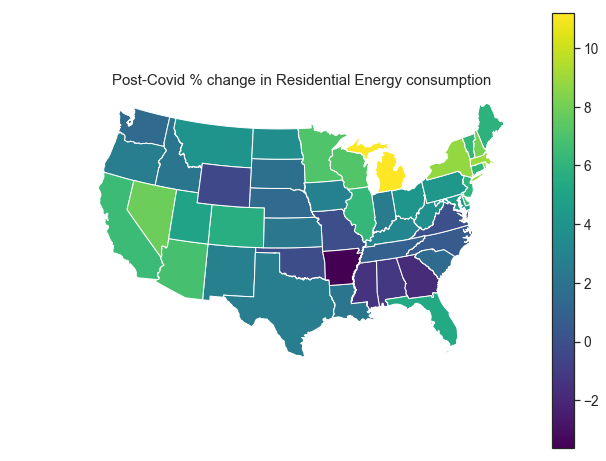

In [421]:
sns.set_style('white')
fig,ax = plt.subplots(figsize=(10,8))
gdf.plot(column='change',ax=ax, legend=True, cmap='viridis')
plt.title("Post-Covid % change in Residential Energy consumption")
ax.set_axis_off()

In [447]:
energy_data.to_csv('energy/energy_data_with_predictions.csv',index=False)

## Statsmodels Time-series analysis

In [ ]:
ts = energy_data[(energy_data.sector=='RES')].copy()
ts['date'] = ts.month + '01'
ts.set_index('date', inplace=True)
ts.index = pd.to_datetime(ts.index)

In [ ]:
state_dummies = pd.get_dummies(ts['state'])
ts = pd.concat([ts,state_dummies],axis=1)

In [ ]:
state_dummies.columns

In [ ]:
from statsmodels.tsa.seasonal import STL

In [ ]:
exog.dropna()

In [ ]:
energy_data['t'] = [x+'01' for x in energy_data.month]
energy_data['date'] = pd.to_datetime(energy_data.t)

In [ ]:
fig,ax = plt.subplots(figsize=(20,10))
sns.lineplot(x='date',y='use_per_capita',data=energy_data[(energy_data.state=='NY')&(energy_data.sector=='RES')])
plt.ylabel('Montly Use per capita (kwh)')
plt.xlabel('Month')

## Modeling with statsmodels

In [ ]:
## divide by number of days per month
## Weekends per month


In [ ]:
## GEt NY ISO granular data (15 min resolution)

In [ ]:
state_level_data =  energy_data[energy_data.state != 'USA'].copy()

In [ ]:
state_level_data['year_l1'] = state_level_data.year - 1
state_level_data['mon_l1'] = state_level_data.mon - 1
state_level_data = state_level_data.merge(state_level_data[['year','mon','state','sector','use_per_capita']].rename(columns={'year':'year_l1','use_per_capita':'y_sl1'}),how='left',left_on=['year_l1','mon','state','sector'],right_on=['year_l1','mon','state','sector'])
state_level_data = state_level_data.merge(state_level_data[['year','mon','state','sector','use_per_capita']].rename(columns={'mon':'mon_l1','use_per_capita':'y_l1'}),how='left',left_on=['year','mon_l1','state','sector'],right_on=['year','mon_l1','state','sector'])

In [ ]:
state_level_data.head()

In [ ]:
state_level_data = state_level_data.dropna()

In [ ]:
state_level_data['yhat'] = np.NaN
# state_level_data['yhat_20'] = np.NaN

In [ ]:
mod_19_res = smf.ols(formula='use_per_capita ~  time + y_sl1 + heating_days + cooling_days + C(state)', data=state_level_data[(state_level_data.year < 2019)&(state_level_data.sector=='RES')])
mod_20_res = smf.ols(formula='use_per_capita ~  time + y_sl1 + heating_days + cooling_days + C(state)', data=state_level_data[(state_level_data.year < 2020)&(state_level_data.sector=='RES')])
mod_19_com = smf.ols(formula='use_per_capita ~  time + y_sl1 + heating_days + cooling_days + C(state)', data=state_level_data[(state_level_data.year < 2019)&(state_level_data.sector=='COM')])
mod_20_com = smf.ols(formula='use_per_capita ~  time + y_sl1 + heating_days + cooling_days + C(state)', data=state_level_data[(state_level_data.year < 2020)&(state_level_data.sector=='COM')])

In [ ]:
res_19_res = mod_19_res.fit()
res_20_res = mod_20_res.fit()
res_19_com = mod_19_com.fit()
res_20_com = mod_20_com.fit()



In [ ]:
# md = smf.mixedlm('use_per_capita ~ time + time^2 + y_l1 + heating_days + cooling_days', data=state_level_data[(state_level_data.year < 2019)&(state_level_data.sector=='COM')&(state_level_data.region=='ESC')], groups=state_level_data[(state_level_data.year < 2019)&(state_level_data.sector=='COM')&(state_level_data.region=='ESC')]["state"])
# mdf = md.fit()
# print(mdf.summary())

In [ ]:
print(res_19_com.summary())

## To Do:
- Outcome variable: Average per day
- % of days that are weekends or holidays
- 1 month lagged (AR-1), last 3 month average
- % above last 12m avg usage

- Stan model
- Take pieces from Prophet (fourier expansion for seasonality): get the stan code
- weather data maybe

In [ ]:
state_level_data.set_index('date',inplace=True)

In [ ]:
state_level_data.loc[(state_level_data.year<=2019)&(state_level_data.sector=='RES'),'yhat'] = res_19_res.predict(state_level_data[(state_level_data.year<=2019)&(state_level_data.sector=='RES')])
state_level_data.loc[(state_level_data.year==2020)&(state_level_data.sector=='RES'),'yhat'] = res_20_res.predict(state_level_data[(state_level_data.year==2020)&(state_level_data.sector=='RES')])
state_level_data.loc[(state_level_data.year<=2019)&(state_level_data.sector=='COM'),'yhat'] = res_19_com.predict(state_level_data[(state_level_data.year<=2019)&(state_level_data.sector=='COM')])
state_level_data.loc[(state_level_data.year==2020)&(state_level_data.sector=='COM'),'yhat'] = res_20_com.predict(state_level_data[(state_level_data.year==2020)&(state_level_data.sector=='COM')])

In [ ]:
fig,ax = plt.subplots(figsize=(20,10))
df_plot = state_level_data[(state_level_data.state=='NY')&(state_level_data.sector=='RES')].copy()
df_plot = df_plot.set_index('date')
df_plot.loc[df_plot.year == 2020, 'yhat'] = np.NaN
df_plot = df_plot[['use_per_capita','yhat']].rename(columns={'use_per_capita':'Actual','yhat':'Predicted'})
sns.lineplot(data=df_plot)
plt.ylabel('Montly Use per capita (kwh)')
plt.xlabel('Month')


In [ ]:
state_level_data['pct_error'] = (state_level_data['use_per_capita'] - state_level_data['yhat'])*100/state_level_data['use_per_capita']
# state_level_data['pct_error_20'] = (state_level_data['yhat_20'] - state_level_data['use_per_capita'])*100/state_level_data['use_per_capita']

In [ ]:
sns.boxplot(x='sector',y='pct_error',data=state_level_data)

In [ ]:
state_level_data = state_level_data.set_index('month').sort_index()

In [ ]:
state_level_data[(state_level_data.mon == 2)&(state_level_data.state=='CA')&(state_level_data.sector=='RES')].use_per_capita.plot()

In [ ]:
sns.boxplot(x='mon',y='pct_error',data=state_level_data[state_level_data.sector=='COM'])

In [ ]:
sns.boxplot(x='mon',y='pct_error_19',data=state_level_data[state_level_data.sector=='RES'])

In [ ]:
sns.boxplot(x='mon',y='pct_error_19',data=state_level_data[state_level_data.sector=='COM'])

In [ ]:
fig,ax = plt.subplots(figsize=(20,10))
sns.boxplot(x='state',y='pct_error_19',data=state_level_data[state_level_data.sector=='RES'])

In [ ]:
fig,ax = plt.subplots(figsize=(20,10))
sns.boxplot(x='state',y='pct_error_19',data=state_level_data[state_level_data.sector=='COM'])

In [ ]:
state_level_data.pct_error_19.plot()

In [ ]:
df_plot = state_level_data[(state_level_data.state == 'NY')&(state_level_data.sector=='RES')&(state_level_data.year>=2019)]

In [ ]:
df_plot.set_index('month').sort_index().pct_error.plot()

In [ ]:
df_plot = state_level_data[(state_level_data.state == 'NY')&(state_level_data.sector=='COM')&(state_level_data.year>=2019)]

In [ ]:
df_plot.set_index('month').sort_index().pct_error.plot()

In [ ]:
state_level_data.head()

In [ ]:
state_level_data.reset_index(inplace=True)

In [ ]:
def state_plot(df, state, sector, year_lim=2019):
    df_plot = df[(df.state==state)&(df.sector==sector)&(df.year>=year_lim)].copy()
    fig,ax = plt.subplots(figsize=(15,6))
    mean_error_before = df_plot[(df_plot.date<'2020-03-01')].pct_error.mean()
    mean_error_after = df_plot[(df_plot.date>='2020-03-01')].pct_error.mean()
    
    df_plot = df_plot.set_index('date')
    df_plot.pct_error.plot(ax=ax)
    plt.xlabel('Month')
    plt.ylabel('% Error in prediction')
    plt.axvline(x=datetime(2020,3,1),color='#f76d23',linestyle='dotted')
    plt.axhline(y=mean_error_before, xmin=0, xmax=0.67, color='r', linestyle='--')
    plt.axhline(y=mean_error_after, xmin=0.67, xmax=1, color='g', linestyle='--')
    plt.text(x=datetime(2020,3,1),y=((mean_error_after+mean_error_before)/2),s= "{}% change".format(np.round(mean_error_after-mean_error_before,2)))
    
#     plt.axvline()

In [ ]:
state_plot(state_level_data,'NY','RES')

In [ ]:
state_plot(state_level_data,'NY','COM')